### Nature of Defect[NOD] Classifier

#### Problem Statement:
Generating monthly appliance replacement reports is a time-consuming process, typically taking two days. The main challenge involves manually reading each observation and accurately classifying it under a pre-defined Nature of Defect (NOD) classification.

#### Solution:
To streamline this process, we implemented a Retrieval Augmented Classification approach. This method involves creating embeddings of observations from monthly reports over the past three years, as well as from the current report. By computing similarity scores between these embeddings, we can automatically assign the most similar NOD label to each observation in the current report.

#### Results:
This automation has significantly reduced the lead time for generating monthly appliance replacement reports—from two days to just 20 minutes. This improvement not only enhances efficiency but also ensures consistency and accuracy in classification across reports.

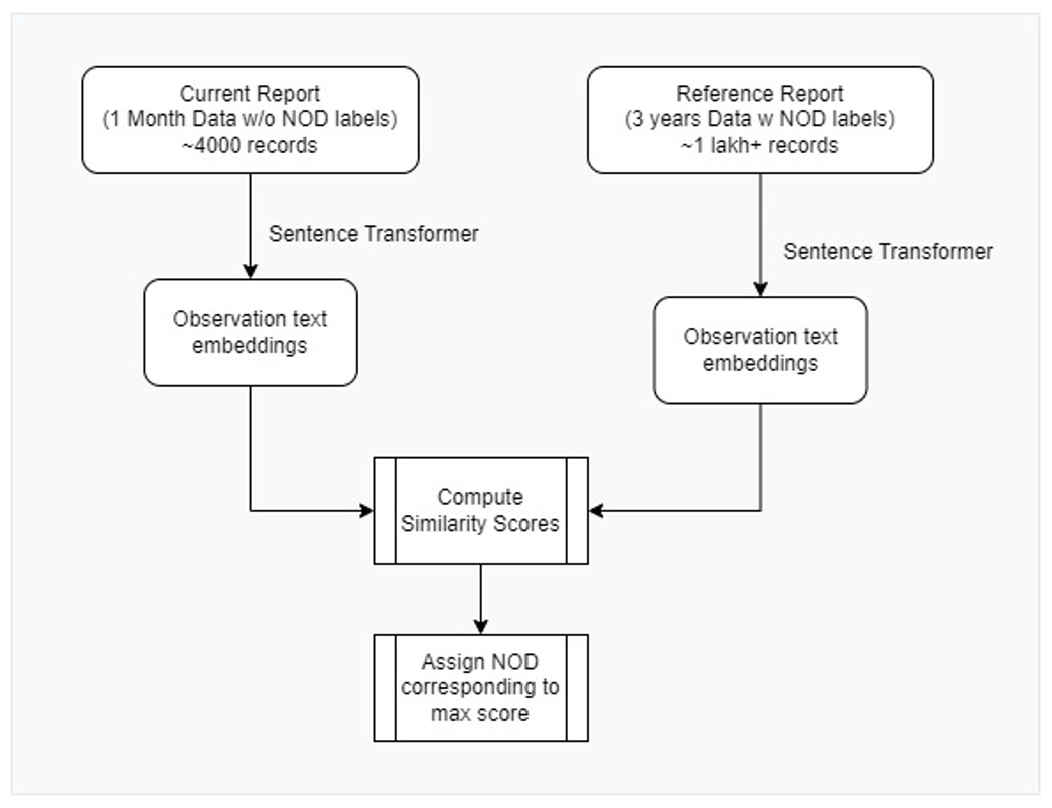

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm.auto import tqdm

# Load your dataframes
main_df_path = r"/content/Four.xlsx" # Four.xlsx is the report file on which we carry out the classification
lookup_df_path = r"/content/Sanctioned PRA 20-21new.xlsx" # Sanctioned PRA 20-21new.xlsx is our reference file having records from last 3 years
output_df_path = r"/content/Five.xlsx" # Five.xlsx is the output file with NOD labels

lookup_df = pd.read_excel(lookup_df_path)
main_df = pd.read_excel(main_df_path)

# Fill NaN with empty strings
lookup_df.fillna('', inplace=True)
main_df.fillna('', inplace=True)

# Initialize the SentenceTransformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Prepare the lookup dictionary
lookup_dict = {}
# Loop through each row in the lookup DataFrame to populate the lookup dictionary
# This dictionary will map job codes to observations and their respective NOD (Nature of Defect)
for _, row in tqdm(lookup_df.iterrows(), desc="Preparing lookup dictionary"):
    job_code = row['JobCode 1']
    observation = row['Observation/Defects']
    nod = row['NOD']
    if job_code not in lookup_dict:
        lookup_dict[job_code] = {}
    if observation not in lookup_dict[job_code]:
        lookup_dict[job_code][observation] = nod

# Function to compute embeddings using Sentence Transformers
# This function takes a list of texts and returns their embeddings
def compute_embeddings(texts):
    return model.encode(texts, show_progress_bar=False)

# Compute embeddings for unique lookup observations
lookup_embeddings = {}
# Loop through the lookup dictionary to compute embeddings for each observation
for job_code, obs_dict in tqdm(lookup_dict.items(), desc="Job Codes"):
    texts = list(obs_dict.keys())
    embeddings = compute_embeddings(texts)
    lookup_embeddings[job_code] = {text: emb for text, emb in zip(texts, embeddings)}

# Process the main file
results = []
# Iterate through each row in the main DataFrame to find the best matching observation from the lookup dictionary
for _, row in tqdm(main_df.iterrows(), desc="Processing main dataset"):
    job_code = row['JobCode 1']
    observation = row['Observation/Defects']
    if job_code in lookup_embeddings:
        observation_embedding = compute_embeddings([observation])[0]  # Compute embedding for the single observation

        # Calculate similarities
        similarities = [np.dot(observation_embedding, lookup_emb) / (np.linalg.norm(observation_embedding) * np.linalg.norm(lookup_emb)) for lookup_emb in lookup_embeddings[job_code].values()]
        max_sim_index = np.argmax(similarities)
        max_sim_observation = list(lookup_dict[job_code].keys())[max_sim_index]
        nod = lookup_dict[job_code][max_sim_observation]
        results.append((nod, max(similarities)))
    else:
        results.append((None, 0))

# Add results to the DataFrame and save
main_df['NOD'], main_df['Similarity Score'] = zip(*results)
main_df.to_excel(output_df_path,index=False)


#### Result Discussion

Previously we used vlookup using Jobcode 1 which couldd not take into account observations. With this script we are able to infer NOD correctly with observation taking precedence in classifying Nature of Defect. Few examples illustrated in below table :

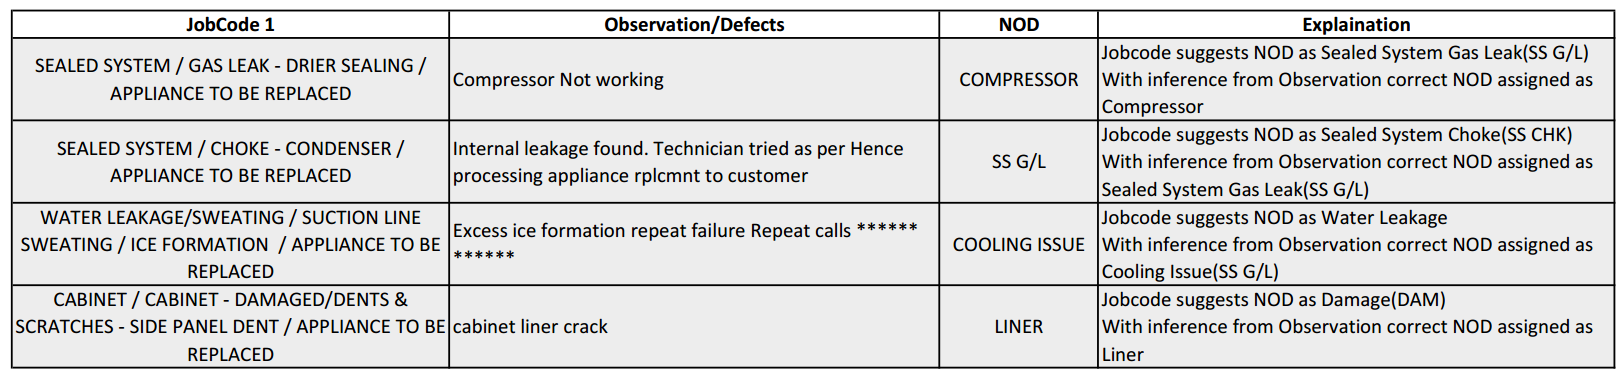